In [ ]:
!pip install biopython requests

In [ ]:
pathway = "aspartate to methionine"
organism = "eco"  # KEGG code for E. coli

## KEGG

In [ ]:
import requests
import re

def get_kegg_enzymes(pathway_id):
    url = f"http://rest.kegg.jp/get/{pathway_id}"
    response = requests.get(url)
    response.raise_for_status()

    # Find all EC numbers using regular expression
    ec_pattern = re.compile(r'EC:(\d+\.\d+\.\d+\.\d+)')
    enzymes = ec_pattern.findall(response.text)

    return list(set(enzymes))

# Methionine biosynthesis pathway (eco00270)
enzyme_list = get_kegg_enzymes("eco00270")
print(f"Found enzymes: {enzyme_list}")

Found enzymes: ['3.2.2.9', '4.4.1.13', '2.5.1.48', '6.3.2.2', '2.5.1.47', '2.1.1.14', '2.1.1.37', '2.5.1.6', '2.4.2.1', '2.7.2.4', '2.3.1.46', '2.6.1.57', '2.1.1.13', '2.5.1.144', '2.6.1.42', '6.3.2.3', '1.2.1.11', '2.7.1.39', '4.3.1.17', '1.1.1.95', '1.1.1.37', '2.8.1.1', '2.3.1.30', '2.5.1.16', '1.8.4.14', '4.4.1.21', '2.6.1.1', '2.1.1.10', '4.4.1.15', '2.6.1.52', '4.1.1.50']


## NCBI Data (upstream.fa)

In [ ]:
from Bio import Entrez
from Bio import SeqIO
from Bio.Seq import Seq
import time
import json
from datetime import datetime
import traceback

Entrez.email = "your@mail.com"
Entrez.api_key = "NCBI API"  # NCBI API

open("sequence_errors.log", "w").close()

In [ ]:
def debug_log(error_type, ec_number, details):
    timestamp = datetime.now().isoformat()
    log_entry = {
        "timestamp": timestamp,
        "ec_number": ec_number,
        "error_type": error_type,
        "details": details
    }
    print(f"DEBUG LOG [{timestamp}]")
    print(json.dumps(log_entry, indent=2))
    with open("sequence_errors.log", "a") as log_file:
        log_file.write(json.dumps(log_entry) + "\n")

In [ ]:
def find_in_structure(data, target_keys):
    if isinstance(data, dict):
        if all(k in data for k in target_keys):
            return data
        for v in data.values():
            result = find_in_structure(v, target_keys)
            if result: return result
    elif isinstance(data, list):
        for item in data:
            result = find_in_structure(item, target_keys)
            if result: return result
    return None

In [ ]:
def parse_gene_location(record, ec_number):
    try:
        # Search for location structure
        loc_data = find_in_structure(
            record,
            ['Seq-interval_from', 'Seq-interval_to', 'Seq-interval_strand']
        )

        if not loc_data:
            raise ValueError("Location structure not found in XML")

        start = int(loc_data['Seq-interval_from'])
        end = int(loc_data['Seq-interval_to'])
        strand_char = loc_data['Seq-interval_strand']['Na-strand']
        strand = 1 if strand_char == 'plus' else -1

        return start, end, strand

    except Exception as e:
        # Save XML for debugging
        with open(f"error_{ec_number}.xml", "w") as f:
            f.write(str(record))
        debug_log("LOCATION_PARSE_ERROR", ec_number, str(e))
        raise

In [ ]:
def get_upstream_sequences(enzyme_list, output_file="upstream.fa", upstream=200):
    open("sequence_errors.log", "w").close()

    # Get chromosome sequence as string
    try:
        print("Fetching E. coli chromosome...")
        handle = Entrez.efetch(db="nucleotide", id="NC_000913", rettype="fasta", retmode="text")
        chr_record = SeqIO.read(handle, "fasta")
        chr_seq_str = str(chr_record.seq)
        print(f"Chromosome loaded: {len(chr_seq_str):,} bp")
    except Exception as e:
        debug_log("CHROMOSOME_FETCH_ERROR", "ALL", str(e))
        raise

    with open(output_file, "w") as fasta_file:
        success_count = 0

        for ec_number in enzyme_list:
            gene_ids = None
            try:
                # Gene Search
                search_term = f"{ec_number}[ECN] AND Escherichia coli K-12[ORGN]"
                debug_log("SEARCH_START", ec_number, {"term": search_term})

                search_handle = Entrez.esearch(db="gene", term=search_term)
                search_result = Entrez.read(search_handle)
                gene_ids = search_result.get("IdList", [])

                if not gene_ids:
                    debug_log("NO_GENE_FOUND", ec_number, search_result)
                    continue

                gene_id = gene_ids[0]
                debug_log("GENE_FOUND", ec_number, {"gene_id": gene_id})

                # Gene Data Retrieval
                gene_handle = Entrez.efetch(db="gene", id=gene_id, retmode="xml")
                gene_record = Entrez.read(gene_handle)

                # Location Parsing
                start, end, strand = parse_gene_location(gene_record, ec_number)
                debug_log("LOCATION_PARSED", ec_number, {
                    "start": start,
                    "end": end,
                    "strand": strand
                })

                # Sequence Extraction
                # 0-based indexing (GenBank uses 1-based)
                start_0 = start - 1
                end_0 = end - 1

                if strand == 1:
                    seq_start = max(0, start_0 - upstream)
                    upstream_seq = chr_seq_str[seq_start:start_0]
                else:
                    seq_end = min(len(chr_seq_str), end_0 + upstream)
                    upstream_seq = str(Seq(chr_seq_str[end_0:seq_end]).reverse_complement())

                fasta_file.write(f">{ec_number}|{gene_id}\n{upstream_seq}\n")
                success_count += 1
                debug_log("SEQUENCE_SAVED", ec_number, {
                    "gene_id": gene_id,
                    "length": len(upstream_seq)
                })

                # Rate limit
                time.sleep(0.5)

            except Exception as e:
                debug_log("PROCESSING_ERROR", ec_number, {
                    "exception": str(e),
                    "gene_ids": gene_ids,
                    "traceback": traceback.format_exc()
                })
                continue

    print(f"\nSuccessfully retrieved {success_count}/{len(enzyme_list)} sequences")
    return success_count

In [ ]:
success_count = get_upstream_sequences(enzyme_list)

Fetching E. coli chromosome...
Chromosome loaded: 4,641,652 bp
DEBUG LOG [2025-06-01T11:04:05.565540]
{
  "timestamp": "2025-06-01T11:04:05.565540",
  "ec_number": "3.2.2.9",
  "error_type": "SEARCH_START",
  "details": {
    "term": "3.2.2.9[ECN] AND Escherichia coli K-12[ORGN]"
  }
}
DEBUG LOG [2025-06-01T11:04:06.206119]
{
  "timestamp": "2025-06-01T11:04:06.206119",
  "ec_number": "3.2.2.9",
  "error_type": "GENE_FOUND",
  "details": {
    "gene_id": "948542"
  }
}
DEBUG LOG [2025-06-01T11:04:07.272709]
{
  "timestamp": "2025-06-01T11:04:07.272709",
  "ec_number": "3.2.2.9",
  "error_type": "LOCATION_PARSED",
  "details": {
    "start": 178454,
    "end": 179152,
    "strand": -1
  }
}
DEBUG LOG [2025-06-01T11:04:07.273367]
{
  "timestamp": "2025-06-01T11:04:07.273367",
  "ec_number": "3.2.2.9",
  "error_type": "SEQUENCE_SAVED",
  "details": {
    "gene_id": "948542",
    "length": 200
  }
}
DEBUG LOG [2025-06-01T11:04:07.773644]
{
  "timestamp": "2025-06-01T11:04:07.773644",
  "ec

In [ ]:
if success_count > 0:
    print("\nFASTA file created. Preview:")
    !head -n 4 upstream.fa
else:
    print("\nNo sequences retrieved. Creating placeholder FASTA for MEME.")
    with open("upstream.fa", "w") as f:
        f.write(">placeholder\nACGT"*50 + "\n")


FASTA file created. Preview:
>3.2.2.9|948542
TACGCCCGCGATCGCTCTCGAAGATCCGCAGGATCTCATGTTCGGTTTTAACGCCCTGCGGTGAACGGTAACGACGATGCCAGTTTATTTTTTTTCGGAAATCAATCTGTGCCATGTCCTCTCCCGCGTGAGAAATACGCTTCCCCGTAAGCGCATGGTAAACTATGCCTTCAAATCGGGCTTATCGCGAGTAAATCTAT
>4.4.1.13|946240
GCCAGCGCGGCAAAGTCGTGTTGCCAGAGCGCAGCGATGATATCTTGAATAACAGCCATGGACTTTCCTGTGGAACAGCGTTTAAGCCTTTATCTGCCTATTGTACTCCTGAATCGTCCGGGACGCCTTGATCCCGGACGCAACAATTTAAGACTTTTCACAATAAAATGTCTGCAAAATTGTCCAAAAGTGGCAATGTT


## MEME

### MEME installation

In [ ]:
!apt-get update && apt-get install -y imagemagick ghostscript libxml-parser-perl

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Fetched 257 kB in 2s (146 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package list

In [ ]:
# Download the MEME Suite tarball
!wget https://meme-suite.org/meme/meme-software/5.5.8/meme-5.5.8.tar.gz

# Extract the archive
!tar -xzvf meme-5.5.8.tar.gz

--2025-06-01 11:05:21--  https://meme-suite.org/meme/meme-software/5.5.8/meme-5.5.8.tar.gz
Resolving meme-suite.org (meme-suite.org)... 128.208.8.135
Connecting to meme-suite.org (meme-suite.org)|128.208.8.135|:443... connected.
HTTP request sent, awaiting response... 200 200
Length: unspecified [application/x-gzip]
Saving to: ‘meme-5.5.8.tar.gz.1’

meme-5.5.8.tar.gz.1     [             <=>    ]  53.89M  17.1MB/s    in 3.1s    

2025-06-01 11:05:25 (17.1 MB/s) - ‘meme-5.5.8.tar.gz.1’ saved [56511298]

meme-5.5.8/
meme-5.5.8/MemeSuite.properties.in
meme-5.5.8/configure.ac
meme-5.5.8/build.xml.in
meme-5.5.8/INSTALL
meme-5.5.8/configure
meme-5.5.8/ChangeLog
meme-5.5.8/config/
meme-5.5.8/AUTHORS
meme-5.5.8/website/
meme-5.5.8/tests/
meme-5.5.8/etc/
meme-5.5.8/config.h.in
meme-5.5.8/website.mk
meme-5.5.8/ARCHIVE_REVISION
meme-5.5.8/README
meme-5.5.8/Makefile.am
meme-5.5.8/COPYING
meme-5.5.8/NEWS
meme-5.5.8/scripts/
meme-5.5.8/ARCHIVE_DATE
meme-5.5.8/m4/
meme-5.5.8/doc/
meme-5.5.8/Makefile.i

In [ ]:
!apt-get update
!apt-get install -y build-essential libxml2-dev libxslt1-dev

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

In [ ]:
%cd /content/meme-5.5.8

!./configure --enable-distributed=no --enable-docker=no

!make
!sudo make install

/content/meme-5.5.8
configure: WARNING: unrecognized options: --enable-distributed, --enable-docker
checking for a BSD-compatible install... /usr/bin/install -c
checking whether build environment is sane... yes
checking for a race-free mkdir -p... /usr/bin/mkdir -p
checking for gawk... no
checking for mawk... mawk
checking whether make sets $(MAKE)... yes
checking whether make supports nested variables... yes
checking whether make supports nested variables... (cached) yes
checking for gcc... gcc
checking whether the C compiler works... yes
checking for C compiler default output file name... a.out
checking for suffix of executables... 
checking whether we are cross compiling... no
checking for suffix of object files... o
checking whether the compiler supports GNU C... yes
checking whether gcc accepts -g... yes
checking for gcc option to enable C11 features... none needed
checking whether gcc understands -c and -o together... yes
checking whether make supports the include directive... ye

In [ ]:
!ls /root/bin/meme

/root/bin/meme


In [ ]:
import os
os.environ["PATH"] += ":/root/bin"

In [ ]:
!meme --version

error at: --version
 Usage:	meme	<dataset> [optional arguments]

	<dataset> 		file containing sequences in FASTA format
	[-h]			print this message
	[-o <output dir>]	name of directory for output files
				will not replace existing directory
	[-oc <output dir>]	name of directory for output files
				will replace existing directory
	[-text]			output in text format (default is HTML)
	[-objfun classic|de|se|cd|ce]	objective function (default: classic)
	[-test mhg|mbn|mrs]	statistical test type (default: mhg)
	[-use_llr]		use LLR in search for starts in Classic mode
	[-neg <negdataset>]	file containing control sequences
	[-shuf <kmer>]		preserve frequencies of k-mers of size <kmer> 
				when shuffling (default: 2)
	[-hsfrac <hsfrac>]	fraction of primary sequences in holdout set 
				(default: 0.5)
	[-cefrac <cefrac>]	fraction sequence length for CE region 
				(default: 0.25)
	[-searchsize <ssize>]	maximum portion of primary dataset to use
				for motif search (in characters)
	[-maxsize <ma

### MEME execution

In [ ]:
def run_meme(input_file, output_dir, palindromic=False):
    cmd = f"meme {input_file} -dna -oc {output_dir} -mod zoops -nmotifs 3 -minw 6 -maxw 20"
    if palindromic:
        cmd += " -pal"
    print(f"Running: {cmd}")
    !{cmd}

In [ ]:
run_meme("/content/upstream.fa", "meme_normal")

Running: meme /content/upstream.fa -dna -oc meme_normal -mod zoops -nmotifs 3 -minw 6 -maxw 20
The output directory 'meme_normal' already exists.
Its contents will be overwritten.
BACKGROUND: using background model of order 0
PRIMARY (classic): n 31 p0 31 p1 0 p2 0
SEQUENCE GROUP USAGE-- Starts/EM: p0; Trim: p0; pvalue: p0; nsites: p0,p1,p2
SEEDS: maxwords 6200 highwater mark: seq 31 pos 194
BALANCE: samples 31 chars 6200 nodes 1 chars/node 6200
Initializing the motif probability tables for 2 to 31 sites...
nsites = 31
Done initializing.

seqs=    31, min_w= 200, max_w=  200, total_size=     6200

motif=1
SEED DEPTHS: 2 4 8 16 31
SEED WIDTHS: 6 8 11 15 20
em: w=  20, psites=  31, iter=  40 
motif=2
SEED DEPTHS: 2 4 8 16 31
SEED WIDTHS: 6 8 11 15 20
em: w=  20, psites=  31, iter=  30 
motif=3
SEED DEPTHS: 2 4 8 16 31
SEED WIDTHS: 6 8 11 15 20
em: w=  20, psites=  31, iter=  30 


In [ ]:
run_meme("/content/upstream.fa", "meme_palindromic", palindromic=True)

Running: meme /content/upstream.fa -dna -oc meme_palindromic -mod zoops -nmotifs 3 -minw 6 -maxw 20 -pal
The output directory 'meme_palindromic' already exists.
Its contents will be overwritten.
BACKGROUND: using background model of order 0
PRIMARY (classic): n 31 p0 31 p1 0 p2 0
SEQUENCE GROUP USAGE-- Starts/EM: p0; Trim: p0; pvalue: p0; nsites: p0,p1,p2
SEEDS: maxwords 6200 highwater mark: seq 31 pos 194
BALANCE: samples 31 chars 6200 nodes 1 chars/node 6200
Initializing the motif probability tables for 4 to 62 sites...
nsites = 62
Done initializing.

seqs=    31, min_w= 200, max_w=  200, total_size=     6200

motif=1
SEED DEPTHS: 2 4 8 16 31
SEED WIDTHS: 6 7 8 9 11 12 15 16 20 21
em: w=  21, psites=  31, iter=  40 
motif=2
SEED DEPTHS: 2 4 8 16 31
SEED WIDTHS: 6 7 8 9 11 12 15 16 20 21
em: w=  21, psites=  31, iter=  40 
motif=3
SEED DEPTHS: 2 4 8 16 31
SEED WIDTHS: 6 7 8 9 11 12 15 16 20 21
em: w=  21, psites=  31, iter=  40 


In [ ]:
print("\nMEME RESULTS SUMMARY:")
print("="*50)
print("NORMAL RUN MOTIFS:")
!grep "regular expression" meme-5.5.8/meme_normal/meme.txt -A 5
print("PALINDROMIC RUN MOTIFS:")
!grep "regular expression" meme-5.5.8/meme_palindromic/meme.txt -A 5


MEME RESULTS SUMMARY:
NORMAL RUN MOTIFS:
grep: meme-5.5.8/meme_normal/meme.txt: No such file or directory
PALINDROMIC RUN MOTIFS:
grep: meme-5.5.8/meme_palindromic/meme.txt: No such file or directory


In [ ]:
!zip -r /content/meme_normal.zip /content/meme-5.5.8/meme_normal
!zip -r /content/meme_palindromic.zip /content/meme-5.5.8/meme_palindromic

updating: content/meme-5.5.8/meme_normal/ (stored 0%)
updating: content/meme-5.5.8/meme_normal/meme.txt (deflated 80%)
updating: content/meme-5.5.8/meme_normal/logo1.eps (deflated 69%)
updating: content/meme-5.5.8/meme_normal/logo_rc1.eps (deflated 69%)
updating: content/meme-5.5.8/meme_normal/logo3.eps (deflated 70%)
updating: content/meme-5.5.8/meme_normal/logo_rc3.png (deflated 5%)
updating: content/meme-5.5.8/meme_normal/logo_rc3.eps (deflated 70%)
updating: content/meme-5.5.8/meme_normal/meme.html (deflated 76%)
updating: content/meme-5.5.8/meme_normal/logo2.png (deflated 2%)
updating: content/meme-5.5.8/meme_normal/logo3.png (deflated 7%)
updating: content/meme-5.5.8/meme_normal/logo1.png (deflated 2%)
updating: content/meme-5.5.8/meme_normal/logo_rc2.png (deflated 2%)
updating: content/meme-5.5.8/meme_normal/logo_rc1.png (deflated 3%)
updating: content/meme-5.5.8/meme_normal/logo_rc2.eps (deflated 69%)
updating: content/meme-5.5.8/meme_normal/logo2.eps (deflated 69%)
updating: c

### Display MEME results

In [ ]:
import os

def display_results(output_dir):
    print(f"\nResults from {output_dir}:")
    try:
        # Show MEME text output
        if os.path.exists(f"{output_dir}/meme.txt"):
            print("Motif summary:")
            !head -n 50 {output_dir}/meme.txt | grep -A 15 "regular expression"
        else:
            print(f"Error: meme.txt not found in {output_dir}")

        # Show logos if available
        if os.path.exists(f"{output_dir}/logo1.png"):
            from IPython.display import Image, display
            print("\nMotif logos:")
            for i in range(1, 4):
                img_path = f"{output_dir}/logo{i}.png"
                if os.path.exists(img_path):
                    display(Image(filename=img_path))
                else:
                    print(f"Logo {i} not found")
        else:
            print("Logos not generated - install ghostscript and imagemagick")
    except Exception as e:
        print(f"Error displaying results: {str(e)}")


Results from /content/meme-5.5.8/meme_normal:
Motif summary:

Motif logos:


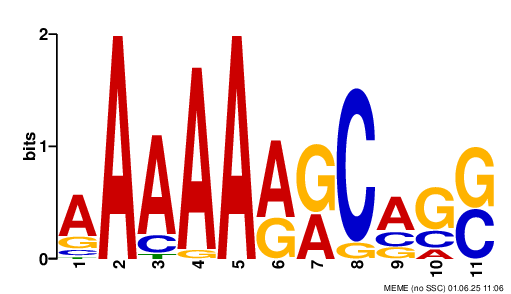

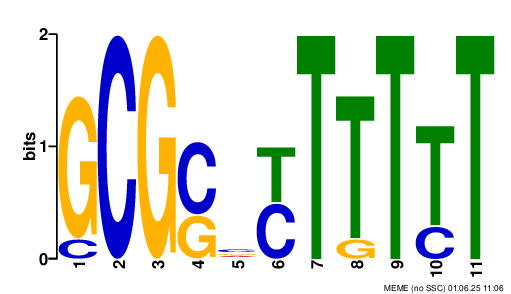

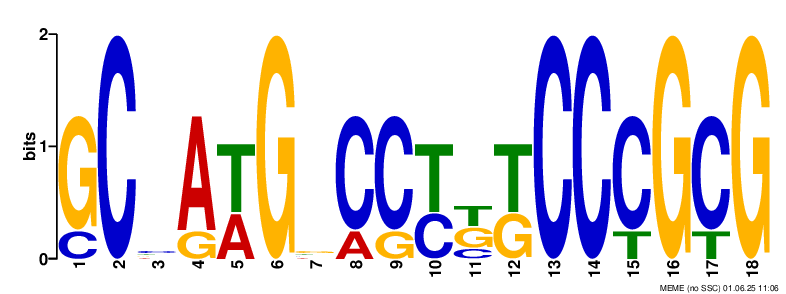

In [ ]:
display_results('/content/meme-5.5.8/meme_normal')


Results from /content/meme-5.5.8/meme_palindromic:
Motif summary:

Motif logos:


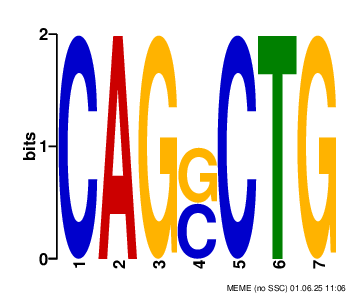

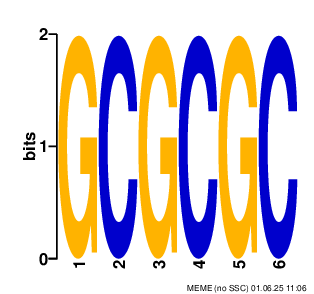

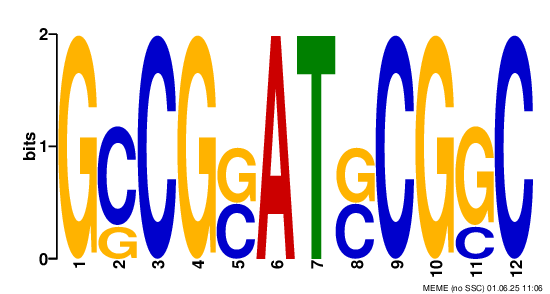

In [ ]:
display_results('/content/meme-5.5.8/meme_palindromic')

## GIBBS

### Normal

In [ ]:
import random

def symbolToNumber(symbol): # symbol is a string of length 1
	if symbol == "A":
		return 0
	if symbol == "C":
		return 1
	if symbol == "G":
		return 2
	if symbol == "T":
		return 3

def numberToSymbol(x): # x is an integer
	if x == 0:
		return "A"
	if x == 1:
		return "C"
	if x == 2:
		return "G"
	if x == 3:
		return "T"

def profileRandom(k, profile, text): # k is an integer, profile is a list of lists of floats, text is a string
    probs = []
    for i in range(0,len(text) - k +1): # for each kmer in text
        prob = 1.0
        pattern = text[i:i+k] # pattern is the kmer
        for j in range(k): # for each symbol in the kmer
            l = symbolToNumber(pattern[j]) # l is the index of the symbol in the profile
            prob *= profile[l][j] # prob is the product of the probabilities of the symbols in the kmer
        probs.append(prob) # add the probability of the kmer to the list of probabilities
    r = myRandom(probs) # r is the index of the kmer with the highest probability
    return r

def profileForm(motifs): # motifs is a list of strings
	k = len(motifs[0]) # k is the length of the first string in motifs
	profile = [[1 for i in range(k)] for j in range(4)] # initialize profile to a list of lists of length k  with all elements initialized to 1
	for x in motifs: # for each string in motifs
		for i in range(len(x)): # for each symbol in the string
			j = symbolToNumber(x[i]) # j is the index of the symbol in the profile
			profile[j][i] += 1 # add 1 to the count of the symbol in the profile
	for x in profile: # for each list in profile
		for i in range(len(x)): # for each element in the list
			x[i] = x[i]/len(motifs) # divide the count of the symbol by the number of strings in motifs
	return profile

def consensus(profile): # profile is a list of lists of floats
	str = ""
	for i in range(len(profile[0])): # for each element in the first list in profile
		max = 0
		loc = 0
		for j in range(4): # for each element in the profile
			if profile[j][i] > max: # if the element in the profile is greater than the current max
				loc = j # set the location to the index of the element in the profile
				max = profile[j][i] # set the max to the element in the profile
		str+=numberToSymbol(loc) # add the symbol corresponding to the location to the string
	return str

def score(motifs): # motifs is a list of strings
	profile = profileForm(motifs) # profile is a list of lists of floats
	cons = consensus(profile) # cons is a string
	score = 0
	for x in motifs: # for each string in motifs
		for i in range(len(x)): # for each symbol in the string
			if cons[i] != x[i]: # if the symbol in the consensus is different from the symbol in the string
				score += 1 # add 1 to the score
	return score

def myRandom(dist): # dist is a list of floats
    s = 0.0
    for x in dist: # for each element in dist
        s+= x # add the element to s
    i = random.random() # i is a random number between 0 and s
    partial = 0.0
    for x in range(len(dist)): # for each element in dist
        partial += dist[x] # add the element to partial
        if partial/s >= i: # if the partial sum divided by s is greater than or equal to i
            return x

def gibbsSampler(dna, k, t, n): # dna is a list of strings, k,t and n are integers
    bestMotifs = []
    motifs = []
    for x in range(t): # for each string in dna
        i = random.randint(0, len(dna[x])-k) # i is a random integer between 0 and the length of the string minus k
        motifs.append(dna[x][i:i+k]) # add the k-mer starting at index i to the motifs list
    bestMotifs = motifs[:] # bestMotifs is a copy of motifs
    for i in range(n): # for each iteration
        j = random.randint(0,t-1) # j is a random integer between 0 and t-1
        profile = profileForm(motifs[:j] + motifs[j+1:]) # profile is a list of lists of floats
        r = profileRandom(k, profile, dna[j]) # r is a random k-mer from the profile
        motifs[j] = dna[j][r:r+k] # set the jth element of motifs to the k-mer starting at index r
        if score(motifs) < score(bestMotifs): # if the score of motifs is less than the score of bestMotifs
            bestMotifs = motifs[:] # set bestMotifs to a copy of motifs
    return bestMotifs

In [ ]:
import random
from Bio import SeqIO

def run_gibbs(input_file, output_dir, num_motifs=3, minw=6, maxw=12, iterations=1000, sampler_runs=20):
    dna_sequences = [str(record.seq) for record in SeqIO.parse(input_file, "fasta")]
    t = len(dna_sequences)  # Number of sequences

    all_best_motifs = []

    for k in range(minw, maxw + 1):
        best_motifs_for_k = None
        best_score = float('inf')

        # Run Gibbs Sampler multiple times
        for _ in range(sampler_runs):
            motifs = gibbsSampler(dna_sequences, k, t, iterations)
            current_score = score(motifs)
            if current_score < best_score:
                best_score = current_score
                best_motifs_for_k = motifs

        # Best result for this k
        all_best_motifs.append((best_score, k, best_motifs_for_k))

    # Sort score
    all_best_motifs.sort(key=lambda x: x[0])
    top_motifs = all_best_motifs[:num_motifs]

    with open(f"{output_dir}/gibbs_results.txt", "a") as f:
        for idx, (score_val, k_val, motifs) in enumerate(top_motifs):
            f.write(f"Motif {idx + 1} (Length {k_val}, Score {score_val}):\n")
            for motif in motifs:
                f.write(f"{motif}\n")
            f.write("\n")

In [ ]:
run_gibbs("/content/upstream.fa", "/content")

#### Logo

In [ ]:
!pip install logomaker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 38.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import logomaker as lm
import matplotlib.pyplot as plt
from collections import defaultdict

In [ ]:
def parse_gibbs_results(file_path):
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]

    motifs = []
    i = 0
    while i < len(lines):
        if lines[i].startswith("Motif"):
            header = lines[i]
            motif_length = int(header.split("Length ")[1].split(",")[0])
            score = int(header.split("Score ")[1].split("):")[0])
            sequences = []
            i += 1
            while i < len(lines) and not lines[i].startswith("Motif"):
                sequences.append(lines[i])
                i += 1
            motifs.append({
                "header": header,
                "length": motif_length,
                "score": score,
                "sequences": sequences
            })
        else:
            i += 1
    return motifs

In [ ]:
def create_pwm(sequences):
    motif_length = len(sequences[0])
    pfm = {
        'A': [0] * motif_length,
        'C': [0] * motif_length,
        'G': [0] * motif_length,
        'T': [0] * motif_length
    }

    # Populate the PFM
    for seq in sequences:
        for idx, base in enumerate(seq):
            pfm[base][idx] += 1

    # Convert PFM to PWM (probabilities)
    pwm = pd.DataFrame(pfm)
    pwm = pwm.div(pwm.sum(axis=1), axis=0)
    return pwm

In [ ]:
def generate_logo(pwm, title):
    plt.figure(figsize=(6.4, 4.8))

    logo = lm.Logo(pwm, color_scheme='classic')
    logo.style_spines(visible=False)
    logo.style_xticks(rotation=0, fmt='%d', fontsize=10)

    plt.title(title)
    plt.xlabel("Position")
    plt.ylabel("Probability")
    plt.tight_layout()
    plt.savefig(f"/content/{title.replace(' ', '_')}.png", dpi=300)
    plt.close()

In [ ]:
motifs = parse_gibbs_results("/content/gibbs_results.txt")

for i, motif in enumerate(motifs):
    pwm = create_pwm(motif['sequences'])
    generate_logo(pwm, f"Motif_{i+1}_Length_{motif['length']}_Score_{motif['score']}_wide")

<Figure size 640x1440 with 0 Axes>

<Figure size 640x1440 with 0 Axes>

<Figure size 640x1440 with 0 Axes>

### Palindromic

In [ ]:
import random

def symbolToNumber(symbol): # symbol is a string of length 1
	if symbol == "A":
		return 0
	if symbol == "C":
		return 1
	if symbol == "G":
		return 2
	if symbol == "T":
		return 3

def numberToSymbol(x): # x is an integer
	if x == 0:
		return "A"
	if x == 1:
		return "C"
	if x == 2:
		return "G"
	if x == 3:
		return "T"

def reverse_complement(seq):
    """Returns the reverse complement of a DNA sequence."""
    complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}
    return ''.join([complement[base] for base in reversed(seq)])

def is_palindrome(seq):
    """Checks if a DNA sequence is a palindrome."""
    return seq == reverse_complement(seq)

def profileRandom(k, profile, text):
    probs = []
    palindromic_indices = []
    for i in range(0, len(text) - k + 1):
        pattern = text[i:i+k]
        if is_palindrome(pattern):
            prob = 1.0
            for j in range(k):
                l = symbolToNumber(pattern[j])
                prob *= profile[l][j]
            probs.append(prob)
            palindromic_indices.append(i)
    if not probs:
        raise ValueError("No palindromic k-mers found in current sequence during selection")
    r = myRandom(probs)
    return palindromic_indices[r]

def profileForm(motifs): # motifs is a list of strings
	k = len(motifs[0]) # k is the length of the first string in motifs
	profile = [[1 for i in range(k)] for j in range(4)] # initialize profile to a list of lists of length k  with all elements initialized to 1
	for x in motifs: # for each string in motifs
		for i in range(len(x)): # for each symbol in the string
			j = symbolToNumber(x[i]) # j is the index of the symbol in the profile
			profile[j][i] += 1 # add 1 to the count of the symbol in the profile
	for x in profile: # for each list in profile
		for i in range(len(x)): # for each element in the list
			x[i] = x[i]/len(motifs) # divide the count of the symbol by the number of strings in motifs
	return profile

def consensus(profile): # profile is a list of lists of floats
	str = ""
	for i in range(len(profile[0])): # for each element in the first list in profile
		max = 0
		loc = 0
		for j in range(4): # for each element in the profile
			if profile[j][i] > max: # if the element in the profile is greater than the current max
				loc = j # set the location to the index of the element in the profile
				max = profile[j][i] # set the max to the element in the profile
		str+=numberToSymbol(loc) # add the symbol corresponding to the location to the string
	return str

def score(motifs): # motifs is a list of strings
	profile = profileForm(motifs) # profile is a list of lists of floats
	cons = consensus(profile) # cons is a string
	score = 0
	for x in motifs: # for each string in motifs
		for i in range(len(x)): # for each symbol in the string
			if cons[i] != x[i]: # if the symbol in the consensus is different from the symbol in the string
				score += 1 # add 1 to the score
	return score

def myRandom(dist): # dist is a list of floats
    s = 0.0
    for x in dist: # for each element in dist
        s+= x # add the element to s
    i = random.random() # i is a random number between 0 and s
    partial = 0.0
    for x in range(len(dist)): # for each element in dist
        partial += dist[x] # add the element to partial
        if partial/s >= i: # if the partial sum divided by s is greater than or equal to i
            return x

def gibbsSampler(dna, k, t, n, minw): # dna is a list of strings, k,t and n are integers
    bestMotifs = []
    # Inside the gibbsSampler function
    motifs = []
    # Inside the motif initialization loop
    for x in range(t):  # for each string in dna
        valid_indices = []
        current_k = k  # Start with the target k
        while current_k >= minw:  # Gradually reduce k until a palindrome is found
            valid_indices = []
            n = len(dna[x])
            for i in range(n - current_k + 1):
                kmer = dna[x][i:i+current_k]
                if is_palindrome(kmer):
                    valid_indices.append(i)
            if valid_indices:
                break  # Exit loop if palindromic k-mers are found
            current_k -= 2  # Reduce k by 2 to preserve symmetry (palindromes are even/odd-length dependent)
        if not valid_indices:
            raise ValueError(f"No palindromic k-mers found in sequence {x} even after adjusting k. Consider expanding minw/maxw.")
        chosen_index = random.choice(valid_indices)
        motifs.append(dna[x][chosen_index:chosen_index+current_k])
    bestMotifs = motifs[:] # bestMotifs is a copy of motifs
    for i in range(n): # for each iteration
        j = random.randint(0,t-1) # j is a random integer between 0 and t-1
        profile = profileForm(motifs[:j] + motifs[j+1:]) # profile is a list of lists of floats
        r = profileRandom(k, profile, dna[j]) # r is a random k-mer from the profile
        motifs[j] = dna[j][r:r+k] # set the jth element of motifs to the k-mer starting at index r
        if score(motifs) < score(bestMotifs): # if the score of motifs is less than the score of bestMotifs
            bestMotifs = motifs[:] # set bestMotifs to a copy of motifs
    return bestMotifs

In [ ]:
import random
from Bio import SeqIO

# Existing utility functions from the original Gibbs Sampler code
# (symbolToNumber, numberToSymbol, profileRandom, profileForm, consensus, score, myRandom, gibbsSampler)

def run_gibbs(input_file, output_dir, num_motifs=3, minw=6, maxw=12, iterations=1000, sampler_runs=20):
    # Step 1: Read DNA sequences from FASTA file
    dna_sequences = [str(record.seq) for record in SeqIO.parse(input_file, "fasta")]
    t = len(dna_sequences)  # Number of sequences

    # Step 2: Initialize list to store best motifs across all k values
    all_best_motifs = []

    # Step 3: Iterate over motif lengths from minw to maxw
    for k in range(minw, maxw + 1):
        best_motifs_for_k = None
        best_score = float('inf')

        # Step 4: Run Gibbs Sampler multiple times for this k
        for _ in range(sampler_runs):
            motifs = gibbsSampler(dna_sequences, k, t, iterations, minw)
            current_score = score(motifs)
            if current_score < best_score:
                best_score = current_score
                best_motifs_for_k = motifs

        # Step 5: Store best result for this k
        all_best_motifs.append((best_score, k, best_motifs_for_k))

    # Step 6: Sort all motifs by score and select top num_motifs
    all_best_motifs.sort(key=lambda x: x[0])
    top_motifs = all_best_motifs[:num_motifs]

    # Step 7: Write results to output file
    with open(f"{output_dir}/gibbs_results_palindromic.txt", "a") as f:
        for idx, (score_val, k_val, motifs) in enumerate(top_motifs):
            f.write(f"Motif {idx + 1} (Length {k_val}, Score {score_val}):\n")
            for motif in motifs:
                f.write(f"{motif}\n")
            f.write("\n")

In [ ]:
run_gibbs("/content/upstream.fa", "/content")